In [1]:
import pandas as pd
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt

To convert the ['Date of Travrel'] values into date format, i used this function authored by @alaudet https://gist.github.com/alaudet/307ac574973028497d083f6d43575214

In [2]:
def date_to_string(digit_date):
    new_form = []
    for d in digit_date:
        try:
            x = datetime.date(1899,12,30) + datetime.timedelta(days=float(d))
            new_form.append(x.strftime('%Y-%m-%d'))
        except:
            new_form.append('n/a')
    return new_form

# Import CSV data

In [127]:
cab_data = pd.read_csv('~/dg_intern/DataSets/Cab_Data.csv')
# the date are converted here, and there's no null value.
cab_data['Date of Travel'] = date_to_string(cab_data['Date of Travel'])
# cab_data['Date of Travel'] = pd.to_datetime(cab_data['Date of Travel'], errors='coerce')
cab_data.head()


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [4]:
list = []
# cab_data_company = pd.read_csv('~/dg_intern/DataSets/Cab_Data.csv', usecols=['Company'])
for name in cab_data['Company']:
    if list != []:
        if name in list:
            continue
        else:
            list.append(name)
    elif list == []:
        list.append(name)
# print(list)
print('The companies we are assessing are ' + str(list))

The companies we are assessing are ['Pink Cab', 'Yellow Cab']


In [5]:
city = pd.read_csv('~/dg_intern/DataSets/City.csv')
print('We have data collected from ' + str(len(city['City'])) + ' cities in total.')
city.head()

We have data collected from 20 cities in total.


,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [6]:
customer_id = pd.read_csv('~/dg_intern/DataSets/Customer_ID.csv')
customer_id.head()


,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [8]:
transaction = pd.read_csv('~/dg_intern/DataSets/Transaction_ID.csv')
transaction.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


# Establish the relational database

In [128]:
output1 = pd.merge(cab_data, transaction, 
                   on='Transaction ID', 
                   how='inner')
cab_trans_customer = pd.merge(output1, customer_id, 
                   on='Customer ID', 
                   how='inner')
cab_trans_customer.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813
1,10351127,2018-07-21,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813
2,10412921,2018-11-23,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813
3,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237
4,10320494,2018-04-21,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237


# General information

## annual profit

In [10]:
profit_pi = [[],[],[]]
profit_ye = [[],[],[]]

# To divide data based on company
for i, name in enumerate(cab_trans_customer['Company']):
    a = cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    if name == 'Pink Cab':
        if cab_trans_customer['Date of Travel'][i][:4] == '2016':
            profit_pi[0].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2017':
            profit_pi[1].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2018':
            profit_pi[2].append(a)
    elif name == 'Yellow Cab':
        if cab_trans_customer['Date of Travel'][i][:4] == '2016':
            profit_ye[0].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2017':
            profit_ye[1].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2018':
            profit_ye[2].append(a)
    else:
        print('missing')
        

In [11]:
ann_profit = np.ma.zeros((2, 3)) # (company, year)
for j in range(3):
        ann_profit[0,j] = sum(profit_pi[j])
        ann_profit[1,j] = sum(profit_ye[j])



In [12]:
print(ann_profit)

[[ 1713511.224       2033654.90800001  1560162.18899998]
 [13926995.43159986 16575977.96800002 13517399.77119991]]


## seasonal profits

In [14]:
profit_pi_sea = [[0]*12 for i in range(3)]
profit_ye_sea = [[0]*12 for i in range(3)]
profit_pi_sea_list = np.ma.zeros((3,12,31))
profit_ye_sea_list = np.ma.zeros((3,12,31))
total_ride_profit = np.ma.zeros((2,3,12,31))
total_day = np.ma.zeros((2,3,12,31))

# To divide data based on company
for i, name in enumerate(cab_trans_customer['Company']):
    a = cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    mon = 10* int(cab_trans_customer['Date of Travel'][i][5]) + int(cab_trans_customer['Date of Travel'][i][6])
    day = 10* int(cab_trans_customer['Date of Travel'][i][8]) + int(cab_trans_customer['Date of Travel'][i][9])
    if name == 'Pink Cab':
        profit_pi_sea[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016][mon-1] += a
        profit_pi_sea_list[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += a
        total_day[0,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += 1
        if a > 0:
            total_ride_profit[0,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += 1
            
        
    elif name == 'Yellow Cab':
        profit_ye_sea[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016][mon-1] += a
        profit_ye_sea_list[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += a
        total_day[1,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += 1
        if a > 0:
            total_ride_profit[1,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += 1
    else:
        print('missing')
        


In [15]:
sea_profit = np.ma.empty((2,3,4)) # two companies, 3 years, 4 seasons
for j in range(3):
    sea_profit[0,j,0] = np.sum(profit_pi_sea_list[j,:3,:])
    sea_profit[0,j,1] = np.sum(profit_pi_sea_list[j,3:6,:])
    sea_profit[0,j,2] = np.sum(profit_pi_sea_list[j,6:9,:])
    sea_profit[0,j,3] = np.sum(profit_pi_sea_list[j,9:12,:])
    
    sea_profit[1,j,0] = np.sum(profit_ye_sea_list[j,:3,:])
    sea_profit[1,j,1] = np.sum(profit_ye_sea_list[j,3:6,:])
    sea_profit[1,j,2] = np.sum(profit_ye_sea_list[j,6:9,:])
    sea_profit[1,j,3] = np.sum(profit_ye_sea_list[j,9:12,:])



# profitable days (rides)

In [16]:
def count_profitable_day(profit):
    profit = np.reshape(profit, -1)
    count = 0
    for i in range(len(profit)):
        if profit[i] > 0:
            count+=1
        else:
            continue 
    return count

In [17]:
def total_day(day):
    day = np.reshape(day, -1)
    day[day == 0] = np.nan
    return len(day[~np.isnan(day)])

In [18]:
profit_day = np.ma.empty((2, 3, 5)) # (company, )
# 2016
for j in range(3):
        profit_day[0,j,0] = count_profitable_day(profit_pi_sea_list[j,:,:]) / total_day(profit_pi_sea_list[j,:,:])
        profit_day[0,j,1] = count_profitable_day(profit_pi_sea_list[j,:3,:]) / total_day(profit_pi_sea_list[j,:3,:])
        profit_day[0,j,2] = count_profitable_day(profit_pi_sea_list[j,3:6,:]) / total_day(profit_pi_sea_list[j,3:6,:])
        profit_day[0,j,3] = count_profitable_day(profit_pi_sea_list[j,6:9,:]) / total_day(profit_pi_sea_list[j,6:9,:])
        profit_day[0,j,4] = count_profitable_day(profit_pi_sea_list[j,9:12,:]) / total_day(profit_pi_sea_list[j,9:12,:])
    
        profit_day[1,j,0] = count_profitable_day(profit_ye_sea_list[j,:,:]) / total_day(profit_ye_sea_list[j,:,:])
        profit_day[1,j,1] = count_profitable_day(profit_ye_sea_list[j,:3,:]) / total_day(profit_ye_sea_list[j,:3,:])
        profit_day[1,j,2] = count_profitable_day(profit_ye_sea_list[j,3:6,:]) / total_day(profit_ye_sea_list[j,3:6,:])
        profit_day[1,j,3] = count_profitable_day(profit_ye_sea_list[j,6:9,:]) / total_day(profit_ye_sea_list[j,6:9,:])
        profit_day[1,j,4] = count_profitable_day(profit_ye_sea_list[j,9:12,:]) / total_day(profit_ye_sea_list[j,9:12,:])


In [19]:
print(profit_day)

[[[0.99726027 1.         0.98901099 1.         1.        ]
  [1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]]

 [[1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]]]


## total seasonal profits/ total annual profits

In [93]:
sea_ann_profit = np.ma.empty((2, 4))
for i in range(2):
    for sea in range(4):
        sum_ann_profit = sum(ann_profit[i, :]) #(company, year)
        sum_sea_profit = sum(sea_profit[i, :, sea]) #(company, year, season)
        sea_ann_profit[i, sea] = sum_sea_profit / sum_ann_profit
        sea_ann_profit[i, sea] = round(sea_ann_profit[i, sea],3)
        

## portion of seasonal profits of each year: seasonal profit each year / total profit each year

In [121]:
sea_profit_annpor = np.ma.empty((2, 3, 4))
for i in range(2):
    for iyear in range(3):
        for k in range(4):
            sea_profit_annpor[i, iyear, k] = sea_profit[i, iyear, k] / ann_profit[i,iyear]
            sea_profit_annpor[i, iyear, k] = "{:.2f}".format(sea_profit_annpor[i, iyear, k])
            

## plots

In [98]:
# print("{:.2f}".format(p) for p in sea_ann_profit[0])
# mm = 100*sea_ann_profit[0]
print(str(100*sea_ann_profit[0][i])+'%')

47.8%


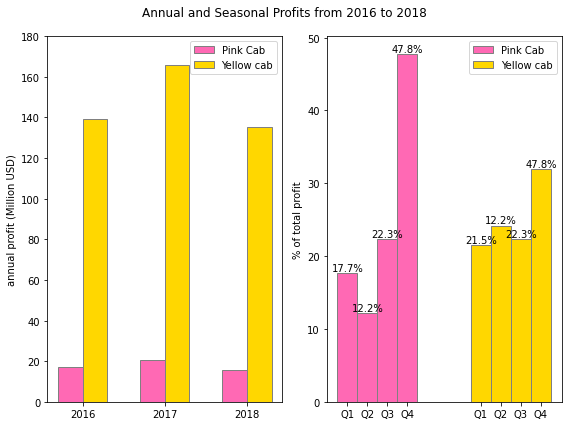

In [187]:
barWidth = 0.3
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
fig, axs = plt.subplots(nrows=1,ncols=2, figsize= (8,6))
fig.suptitle('Annual and Seasonal Profits from 2016 to 2018')
axs[0].bar(br1, ann_profit[0], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
axs[0].bar(br2, ann_profit[1], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[0].legend(['Pink Cab', 'Yellow cab'])
axs[0].set_xticks([r + 0.5*barWidth for r in range(3)], ['2016','2017','2018'])
axs[0].set_yticks(np.arange(0.0e7,2.0e7,0.2e7))
axs[0].set_yticklabels(['0', '20', '40', '60', '80', '100', '120', '140', '160','180'])
axs[0].set_ylabel('annual profit (Million USD)')

# sea_ann_profit
b1 = np.arange(4)
br1 = [x*barWidth for x in b1]
br2 = [2 + x*barWidth for x in b1]

pi_sea = axs[1].bar(br1, sea_ann_profit[0], width = barWidth, color = 'hotpink', align='center', label = 'Pink Cab', edgecolor ='grey')
ye_sea = axs[1].bar(br2, sea_ann_profit[1], width = barWidth, color = 'gold', align='center', label = 'Yellow Cab', edgecolor ='grey')
axs[1].legend(['Pink Cab', 'Yellow cab'])
axs[1].set_xticks([0.0, 0.3, 0.6, 0.8999999999999999,2.0, 2.3, 2.6, 2.9], ['Q1','Q2','Q3','Q4', 'Q1','Q2','Q3','Q4'])
axs[1].set_yticks(np.arange(0,0.6,0.1),[0, 10, 20, 30, 40, 50])
axs[1].set_ylabel('% of total profit')

# # Label with label_type the default 'edge'
axs[1].bar_label(pi_sea,labels=[str(100*sea_ann_profit[0][0])+'%',str(100*sea_ann_profit[0][1])+'%',str(100*sea_ann_profit[0][2])+'%',str(100*sea_ann_profit[0][3])+'%'])
axs[1].bar_label(ye_sea,labels=[str(100*sea_ann_profit[1][0])+'%',str(100*sea_ann_profit[0][1])+'%',str(100*sea_ann_profit[0][2])+'%',str(100*sea_ann_profit[0][3])+'%'])

fig.tight_layout()



Seasonal Profits of from 2016 to 2018
[[[ 249229.59    215246.063   381375.523   867660.048 ]
  [ 358923.005   256717.349   466195.359   951819.195 ]
  [ 331039.887   175183.83    337000.84    716937.632 ]]

 [[2760242.0676 3479801.79   3197747.6144 4489203.9596]
  [3602691.3216 3924204.07   3760758.5584 5288324.018 ]
  [3122695.9248 3235419.0188 2901708.8556 4257575.972 ]]]


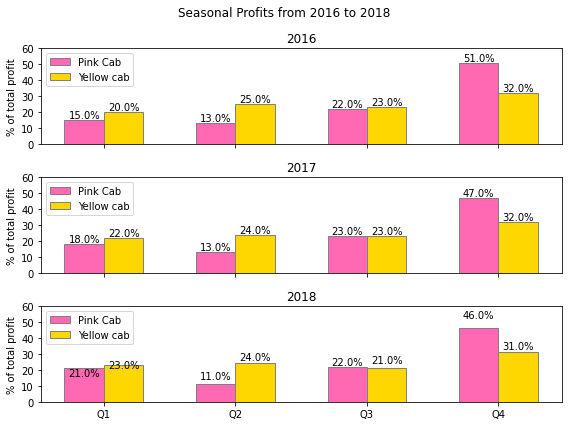

In [123]:
barWidth = 0.3
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]

fig, axs = plt.subplots(3,1, sharex=True, figsize= (8,6))

# fig, axs = plt.subplots(nrows=1,ncols=2, figsize= (8,6))
fig.suptitle('Seasonal Profits from 2016 to 2018')

pi_q1 = axs[0].bar(br1, sea_profit_annpor[0,0,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q1 = axs[0].bar(br2, sea_profit_annpor[1,0,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[0].bar_label(pi_q1,labels=[str(100*sea_profit_annpor[0,0,0])+'%',str(100*sea_profit_annpor[0,0,1])+'%',str(100*sea_profit_annpor[0,0,2])+'%',str(100*sea_profit_annpor[0,0,3])+'%'])
axs[0].bar_label(ye_q1,labels=[str(100*sea_profit_annpor[1,0,0])+'%',str(100*sea_profit_annpor[1,0,1])+'%',str(100*sea_profit_annpor[1,0,2])+'%',str(100*sea_profit_annpor[1,0,3])+'%'])
axs[0].legend(['Pink Cab', 'Yellow cab'])
axs[0].set_title('2016')
axs[0].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[0].set_yticks(np.arange(0,0.7,0.1),[0, 10, 20, 30, 40, 50, 60])
axs[0].set_ylabel('% of total profit')

pi_q2 = axs[1].bar(br1, sea_profit_annpor[0,1,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
ye_q2 = axs[1].bar(br2, sea_profit_annpor[1,1,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[1].bar_label(pi_q2,labels=[str(100*sea_profit_annpor[0,1,0])+'%',str(100*sea_profit_annpor[0,1,1])+'%',str(100*sea_profit_annpor[0,1,2])+'%',str(100*sea_profit_annpor[0,1,3])+'%'])
axs[1].bar_label(ye_q2,labels=[str(100*sea_profit_annpor[1,1,0])+'%',str(100*sea_profit_annpor[1,1,1])+'%',str(100*sea_profit_annpor[1,1,2])+'%',str(100*sea_profit_annpor[1,1,3])+'%'])
axs[1].legend(['Pink Cab', 'Yellow cab'])
axs[1].set_title('2017')
axs[1].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[1].set_yticks(np.arange(0,0.7,0.1),[0, 10, 20, 30, 40, 50, 60])
axs[1].set_ylabel('% of total profit')

axs[2].bar(br1, sea_profit_annpor[0,2,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
axs[2].bar(br2, sea_profit_annpor[1,2,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[2].bar_label(pi_q1,labels=[str(100*sea_profit_annpor[0,2,0])+'%',str(100*sea_profit_annpor[0,2,1])+'%',str(100*sea_profit_annpor[0,2,2])+'%',str(100*sea_profit_annpor[0,2,3])+'%'])
axs[2].bar_label(ye_q1,labels=[str(100*sea_profit_annpor[1,2,0])+'%',str(100*sea_profit_annpor[1,2,1])+'%',str(100*sea_profit_annpor[1,2,2])+'%',str(100*sea_profit_annpor[1,2,3])+'%'])
axs[2].legend(['Pink Cab', 'Yellow cab'])
axs[2].set_title('2018')
axs[2].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[2].set_yticks(np.arange(0,0.7,0.1),[0, 10, 20, 30, 40, 50, 60])
axs[2].set_ylabel('% of total profit')

fig.tight_layout()


## profit on holiday

# city-wise customers

In [166]:
def extract_number(number): # number in the format of ' ' with comma and space.
    number = number.strip()
    count = len(number) //4
    t = 0
    sum = 0
    for i, v in enumerate(number):
        if v == ',':
            continue
        else:
            sum += int(v) * (10**(len(number) - 1 - count - t))
            t += 1  
    return sum

check if there's redundent redord

In [217]:
a = set(cab_trans_customer['City'])
city_name_list = []
for name in city['City']:
    if name in a:
        if name in city_name_list:
            continue
        else:
            city_name_list.append(name)
        continue
    else:
        print('index 14: ' + name + ' is not in the record.')

index 14: SAN FRANCISCO CA is not in the record.


In [185]:
print(city_name_list)

['NEW YORK NY', 'CHICAGO IL', 'LOS ANGELES CA', 'MIAMI FL', 'SILICON VALLEY', 'ORANGE COUNTY', 'SAN DIEGO CA', 'PHOENIX AZ', 'DALLAS TX', 'ATLANTA GA', 'DENVER CO', 'AUSTIN TX', 'SEATTLE WA', 'TUCSON AZ', 'SACRAMENTO CA', 'PITTSBURGH PA', 'WASHINGTON DC', 'NASHVILLE TN', 'BOSTON MA']


In [223]:
# user portion
city_wise_user = np.ma.empty((20))
city_wise_customer = np.ma.zeros((2, 3, 19))

for i, city_name in enumerate(city['City']):
    city_wise_user[i] = extract_number(city['Users'][i]) / extract_number(city['Population'][i])

for i in range(len(cab_trans_customer['City'])):
    for city_name in city['City']:
        if cab_trans_customer['Company'][i] == 'Pink Cab':
            if cab_trans_customer['City'][i] == city_name:
                index = city_name_list.index(city_name)
                if int(cab_trans_customer['Date of Travel'][i][:4]) == 2016:
                    city_wise_customer[0, 0, index] += 1
                if int(cab_trans_customer['Date of Travel'][i][:4]) == 2017:
                    city_wise_customer[0, 1, index] += 1
                if int(cab_trans_customer['Date of Travel'][i][:4]) == 2018:
                    city_wise_customer[0, 2, index] += 1
                    
        if cab_trans_customer['Company'][i] == 'Yellow Cab':
            if cab_trans_customer['City'][i] == city_name:
                index = city_name_list.index(city_name)
                if int(cab_trans_customer['Date of Travel'][i][:4]) == 2016:
                    city_wise_customer[1, 0, index] += 1
                if int(cab_trans_customer['Date of Travel'][i][:4]) == 2017:
                    city_wise_customer[1, 1, index] += 1
                if int(cab_trans_customer['Date of Travel'][i][:4]) == 2018:
                    city_wise_customer[1, 2, index] += 1
                
                

In [ ]:
# check if the number is within the range
for i in range(19):
    if sum(city_wise_customer[0,:,i])+sum(city_wise_customer[1,:,i]) > extract_number(city['Users'][i]):
        print(i, city['City'][i])
        print('number of customers',sum(city_wise_customer[0,:,i])+sum(city_wise_customer[1,:,i]))
        print('number of customers of pink',sum(city_wise_customer[0,:,i]))
        print('number of customers of yellow', sum(city_wise_customer[1,:,i]))
        print('users',city['Users'][i])
    if sum(city_wise_customer[0,:,i])+sum(city_wise_customer[1,:,i]) > extract_number(city['Population'][i]):
        print('error!!')
    

## portion of the customers in different service and city

In [242]:
city_wise_customer_portion = np.ma.zeros((2, 3, 19))
for i in range(2):
    for j in range(3):
        for k in range(19):
            city_wise_customer_portion[i, j, k] = city_wise_customer[i, j, k] / sum(city_wise_customer[:, j, k])
            city_wise_customer_portion[i, j, k] = round(city_wise_customer_portion[i, j, k],3)



## plots

In [244]:
print(city_wise_customer_portion[0, 0])

[0.137 0.166 0.408 0.319 0.444 0.373 0.519 0.423 0.199 0.234 0.365 0.368
 0.345 0.413 0.557 0.52  0.082 0.614 0.172]


## annual

[0.0, 0.3, 0.6, 0.8999999999999999, 1.2, 1.5, 1.7999999999999998, 2.1, 2.4, 2.6999999999999997, 3.0, 3.3, 3.5999999999999996, 3.9, 4.2, 4.5, 4.8, 5.1, 5.3999999999999995]


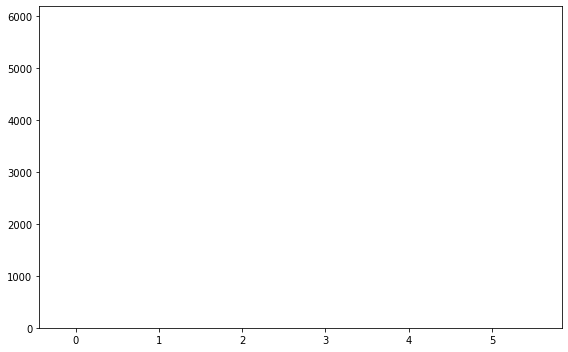

In [237]:
barWidth = 0.3
br1 = np.arange(19)
br2 = [x * barWidth for x in br1]
print(br2)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize= (8,5))

ax.bar(br2, city_wise_customer_portion[0, 0], barWidth, label = 'Pink Cab')
ax.bar(br2, city_wise_customer_portion[1, 0], barWidth, bottom = city_wise_customer[0,0],label='Yellow Cab') 
# for i in range(19):
#        ax.bar(br2[i], city_wise_customer_portion[0, 0, i], barWidth, label = 'Pink Cab')
#        ax.bar(br2[i], city_wise_customer_portion[1, 0, i], barWidth, bottom = city_wise_customer[0,0,i],
#               label='Yellow Cab')
fig.tight_layout()

## seasonal

## city-wise customers

# customer's retention

Customers who used the cab service more than average rides 